In [1]:
using DrWatson; @quickactivate(".")

In [2]:
using Random, Distributions
import Evolutionary as Ev
import CairoMakie as M

# Define negative log-likelihood of a Gaussian mixture

$$
\mathrm{negLL}(x, \theta) = -\frac1N \sum_{n=1}^N \log p(x; \theta)
$$

For a Gaussian mixture of $K$ components, the density is a convex combination of Gaussian (Normal) densities $\phi(\cdot)$:

$$
p(x; \pi, \mu, \sigma) =
\sum_{k=1}^K \pi_k \phi\left(x; \mu_k, \sigma_k \right)
$$

- $\pi_k \in (0, 1)$ - weights
- $\mu_k \in \mathbb{R}$ - means
- $\sigma_k \in \mathbb{R}_+$ - standard deviations

In [3]:
"""
Extract mixture parameters from single vector
containing all concatenated parameters.
"""
function extract_params(params::AbstractVector{<:Real})
    @assert length(params) % 3 == 0
    n_components = div(length(params), 3)

    weights = params[begin:n_components]
    means = params[n_components+1:2n_components]
    standard_deviations = params[2n_components+1:end]

    (; weights, means, stds=standard_deviations)
end;

In [4]:
extract_params([[0.4, 0.6]; [-1, 1]; [0.1, .5]])

(weights = [0.4, 0.6], means = [-1.0, 1.0], stds = [0.1, 0.5])

In [5]:
function negative_loglik_mixture(params::AbstractVector{<:Real}, samples::AbstractVector{<:Real})::Real
    weights, means, stds = extract_params(params)
    mixture = MixtureModel([
        Normal(mean, std) for (mean, std) in zip(means, stds)
    ], weights)

    -1/length(samples) * sum(
        Distributions.logpdf(mixture, sample)
        for sample in samples
    )
end;

# Sample from mixture with given parameters

In [6]:
begin
    params_true = (weights=[0.3, 0.7], means=[-1, 1], stds=[0.1, 0.3])
    distribution = MixtureModel([
        Normal(mean, std)
        for (mean, std) in zip(params_true.means, params_true.stds)
    ], params_true.weights)
    the_samples = rand(MersenneTwister(42), distribution, 1000)
    
    distribution
end

MixtureModel{Normal{Float64}}(K = 2)
components[1] (prior = 0.3000): Normal{Float64}(μ=-1.0, σ=0.1)
components[2] (prior = 0.7000): Normal{Float64}(μ=1.0, σ=0.3)


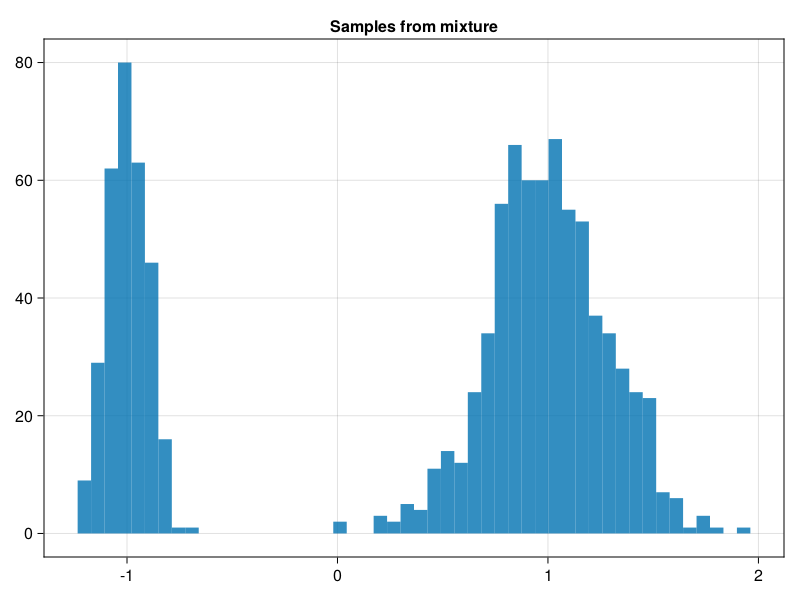

In [7]:
M.hist(the_samples, bins=50, axis=(title="Samples from mixture", ))

Two Gaussian distributions (mixture components) are clearly seen.

# Plot slices of negative log-likelihood

This is a "slice" of the negative log-likelihood along the $(\mu_1, \mu_2)$ plane.

In [8]:
neg_ll_means = let
    true_weights, _, true_stds = params_true
    neg_ll(mean1::Real, mean2::Real) = negative_loglik_mixture(
        [true_weights; [mean1, mean2]; true_stds], the_samples
    )
end

(::var"#neg_ll#7"{Vector{Float64}, Vector{Float64}}) (generic function with 1 method)

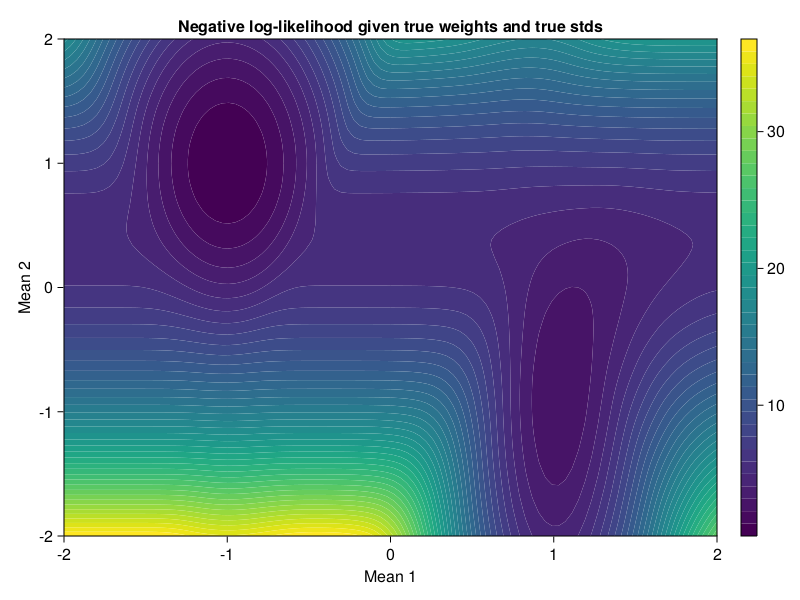

In [9]:
let
    means_range = range(-2, 2, 100)
    neg_logliks = [
        neg_ll_means(mean1, mean2)
        for mean1 in means_range, mean2 in means_range
    ]

    figure, axis, plotobj = M.contourf(
        means_range, means_range, neg_logliks, levels=40,
        axis=(
            xlabel="Mean 1", ylabel="Mean 2",
            title="Negative log-likelihood given true weights and true stds"
        )
    )
    M.Colorbar(figure[1, 2], plotobj)
    figure
end

This slice (evaluated at the _true_ weights and standard deviations!) has two local minima:

1. At about $(\mu_1=-1, \mu_2=1)$. Thus, the optimal parameters are:
    1. $\pi_1=0.3, \mu_1=-1, \sigma_1=0.1$
    2. $\pi_2=0.7, \mu_1=1, \sigma_2=0.5$
2. At about $(\mu_1=1, \mu_2=-1)$. Thus, the optimal parameters are:
    1. $\pi_1=0.3, \mu_1=1, \sigma_1=0.1$
    2. $\pi_2=0.7, \mu_1=-1, \sigma_2=0.5$
    
A similar plot was provided at CrossValidated: https://stats.stackexchange.com/a/265922.
    
So, the densities of the two solutions are:

$$
\begin{aligned}
p_A(x) &= 0.3 N(x; -1, 0.1) + 0.7 N(x; 1, 0.5)\\
p_B(x) &= 0.3 N(x; 1, 0.1) + 0.7 N(x; -1, 0.5)\\
\end{aligned}
$$

However, these are completely different distributions:

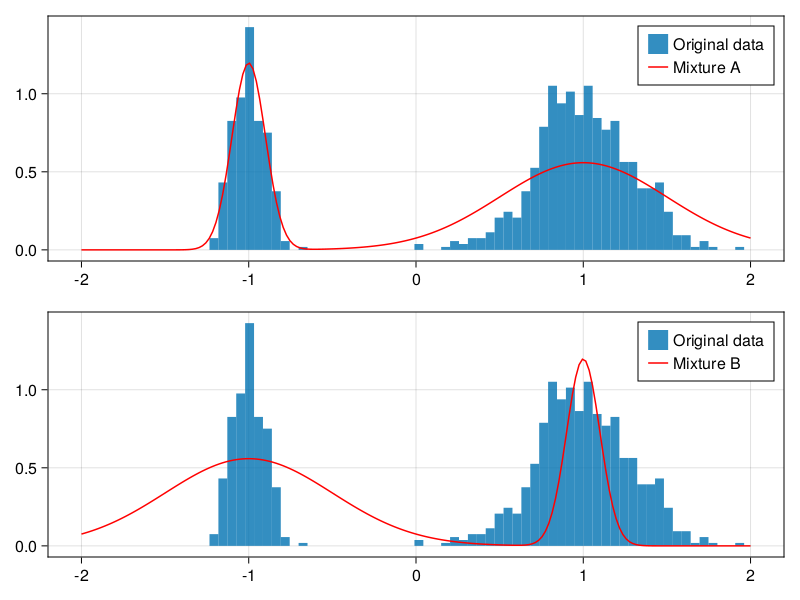

In [10]:
let
    mixA = MixtureModel([
        Normal(-1, 0.1), Normal(1, 0.5)
    ], [0.3, 0.7])
    mixB = MixtureModel([
        Normal(1, 0.1), Normal(-1, 0.5)
    ], [0.3, 0.7])
    
    pdfA(x::Real) = Distributions.pdf(mixA, x)
    pdfB(x::Real) = Distributions.pdf(mixB, x)
    
    X = range(-2, 2, 200) |> collect
    
    fig = M.Figure()
    axA, _ = M.hist(fig[1, 1], the_samples, normalization=:pdf, bins=60, label="Original data")
    M.lines!(axA, X, pdfA.(X), label="Mixture A", color=:red)
    M.axislegend(axA)
    
    axB, _ = M.hist(fig[2, 1], the_samples, normalization=:pdf, bins=60, label="Original data")
    M.lines!(axB, X, pdfB.(X), label="Mixture B", color=:red)
    M.axislegend(axB)
    
    M.linkxaxes!(axA, axB)
    
    fig
end

We know the correct distribution is mixture A. It also looks like a much better fit on the plots above. However, optimization algorithms can't tell the difference.

# Find parameters my minimizing the negative log-likelihood

In [11]:
function estimate(the_samples, means_init::AbstractVector)
    x0 = [[0.5, 0.5]; means_init; [0.01, 0.02]]
    x_lo = [[0, 0]; [-Inf, -Inf]; [0, 0]]
    x_hi = [[1, 1]; [Inf, Inf]; [Inf, Inf]]
    objective(params) = begin
        weights, means, stds = extract_params(params)
        
        # Force weights to be between 0 and 1 and to sum to 1
        weights .= exp.(weights)
        weights ./= sum(weights)
        
        negative_loglik_mixture([weights; means; stds], the_samples)
    end
    
    Ev.optimize(
        objective, Ev.BoxConstraints(x_lo, x_hi), x0, Ev.CMAES(),
        Ev.Options(iterations=1000)
    )
end;

## Initialize means in the upper left corner of the second plot

In [12]:
resA = estimate(the_samples, [-2, 2])


 * Status: success

 * Candidate solution
    Minimizer:  [0.17174910227181275, 0.9859330665648138, -0.9988026933149289,  ...]
    Minimum:    0.4470794661284616
    Iterations: 452

 * Found with
    Algorithm: (10,20)-CMA-ES

 * Convergence measures
    |f(x) - f(x')| = 4.274358644806853e-15 ≤ 1.0e-12

 * Work counters
    Seconds run:   2.6974 (vs limit Inf)
    Iterations:    452
    f(x) calls:    9040


In [13]:
(resA |> Ev.minimizer |> extract_params).means

2-element Vector{Float64}:
 -0.9988026933149289
  1.0007389721617401

## Initialize means in the lower right corner of the second plot

In [14]:
resB = estimate(the_samples, [2, -2])


 * Status: success

 * Candidate solution
    Minimizer:  [0.9999995978832799, 0.3349990581277029, 1.0207090715013563,  ...]
    Minimum:    0.9141625405248843
    Iterations: 346

 * Found with
    Algorithm: (10,20)-CMA-ES

 * Convergence measures
    |f(x) - f(x')| = 1.0802470029602773e-13 ≤ 1.0e-12

 * Work counters
    Seconds run:   2.3443 (vs limit Inf)
    Iterations:    346
    f(x) calls:    6920


In [15]:
(resB |> Ev.minimizer |> extract_params).means

2-element Vector{Float64}:
  1.0207090715013563
 -0.8455930189597262

By changing sign of initial mean estimate we got mean estimates with different signs, as predicted in the previous section!